In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers
import warnings

In [ ]:
df = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")
df.head(10)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
5,Image_6.jpg,CAIRNS BIRDWING
6,Image_7.jpg,GREEN CELLED CATTLEHEART
7,Image_8.jpg,EASTERN DAPPLE WHITE
8,Image_9.jpg,BROWN SIPROETA
9,Image_10.jpg,RED POSTMAN


In [ ]:
len(df)

6499

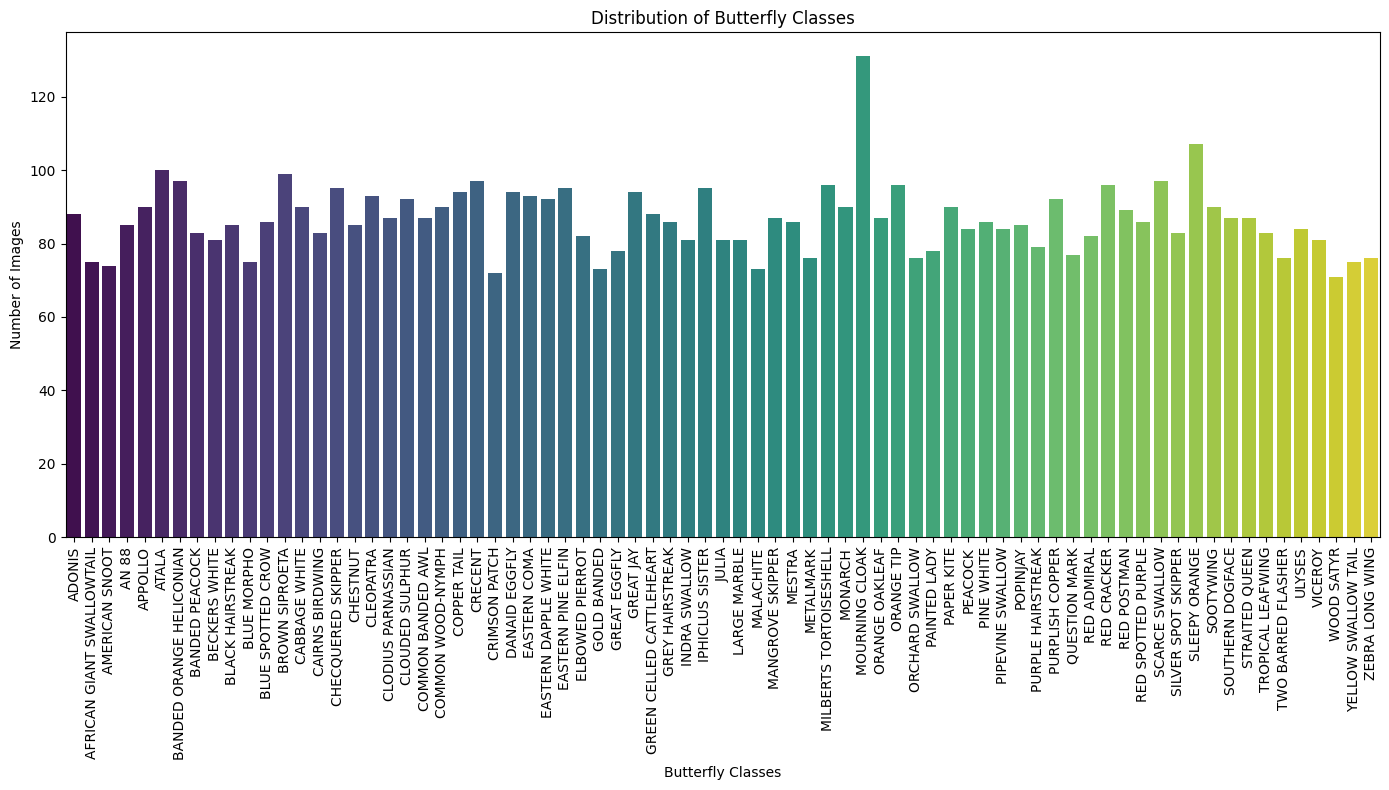

In [ ]:
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Butterfly Classes')
plt.xlabel('Butterfly Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

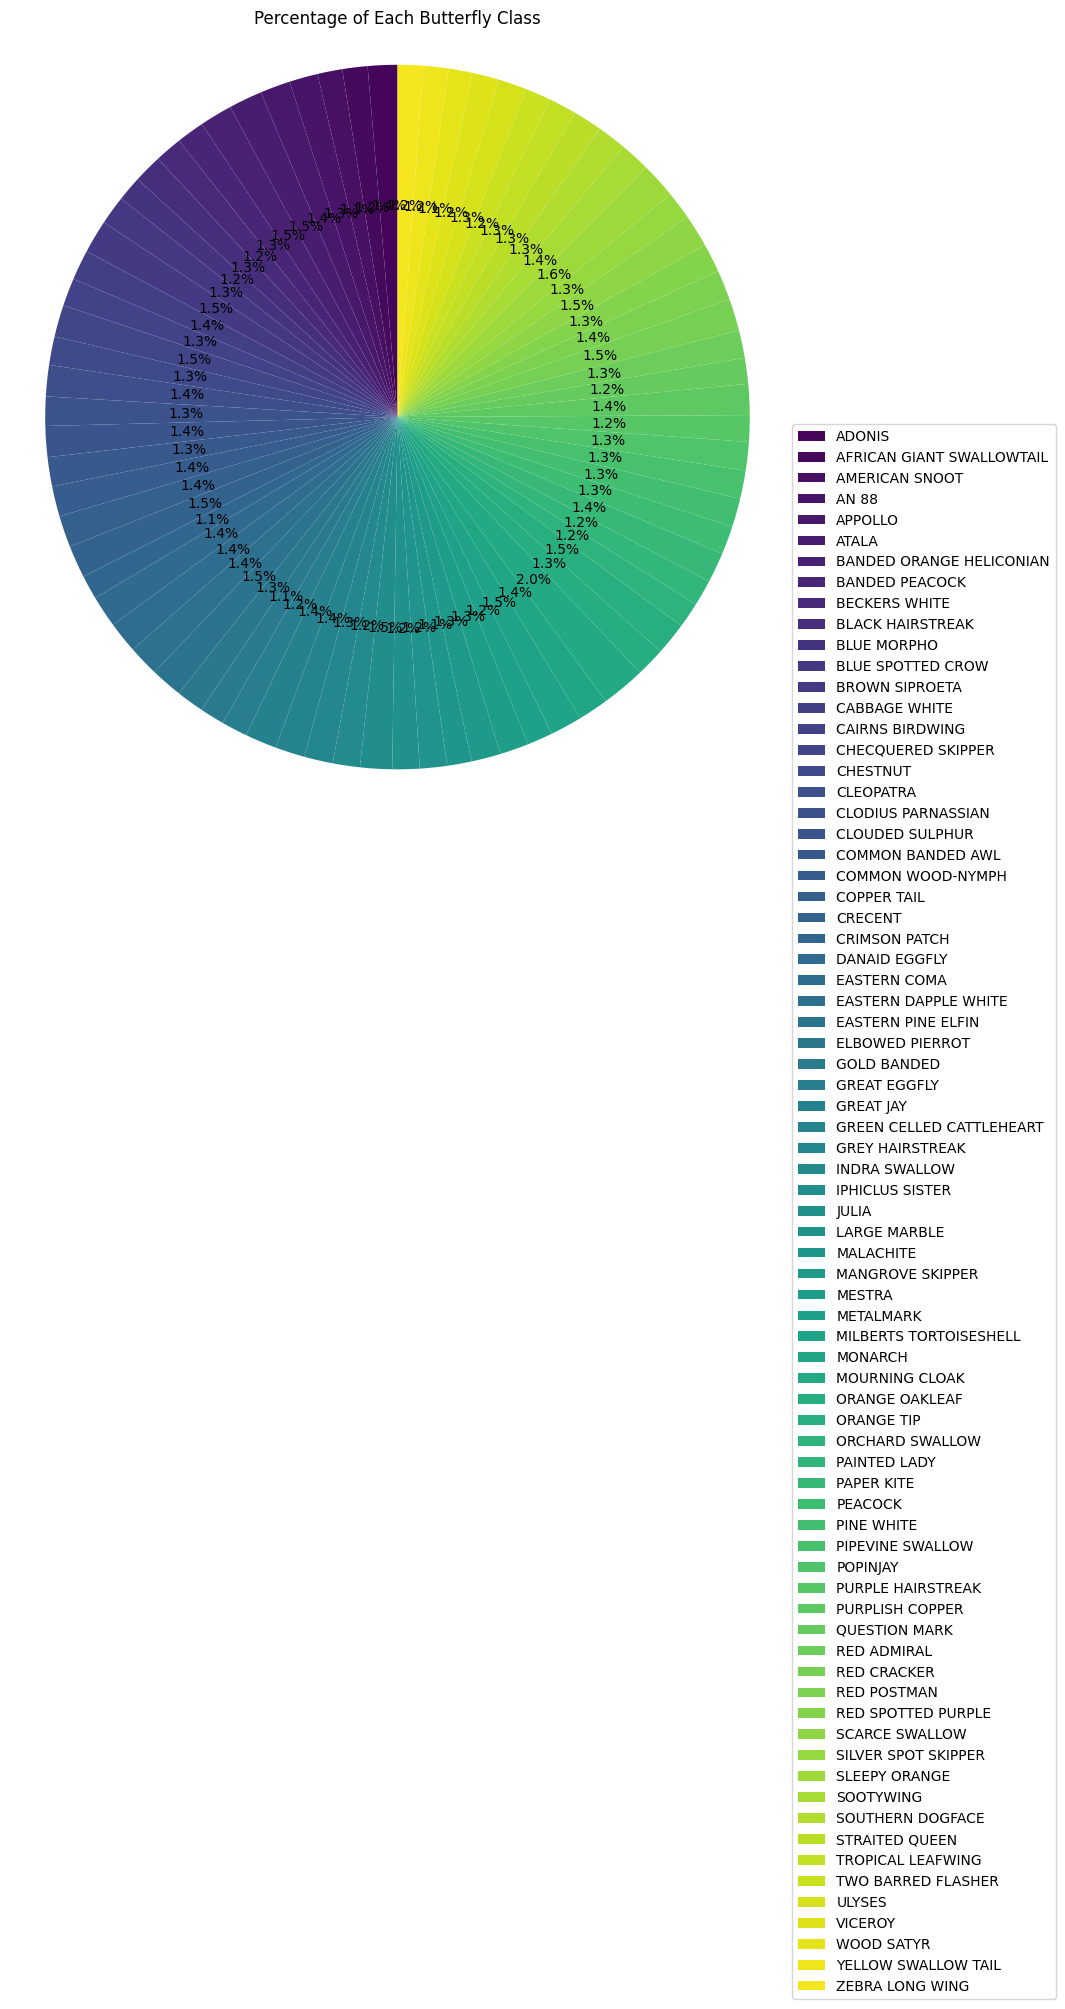

In [ ]:
colors = sns.color_palette("viridis", len(class_counts))
class_counts = df['label'].value_counts().sort_index()


plt.figure(figsize=(10, 10))
plt.pie(class_counts.values, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Each Butterfly Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(class_counts.index, loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
image_dir = "/kaggle/input/butterfly-image-classification/train"

sample_images = df.sample(9, random_state=42)


fig, axes = plt.subplots(3, 3, figsize=(15, 15))


for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['filename'])
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image

    ax = axes[i // 3, i % 3]
    ax.imshow(img_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = "/kaggle/input/butterfly-image-classification/train"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>🦋 Building the Model 🦋</b></div>

In [ ]:
from tensorflow.keras import layers, models

model_CNN = models.Sequential([
    layers.Input(shape=(150, 150, 3)),  # Define the input shape
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(75, activation='softmax')
])

model_CNN.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,072,139 (72.75 MB)

 Trainable params: 19,072,139 (72.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 161s 968ms/step - accuracy: 0.0490 - loss: 4.0995 - val_accuracy: 0.2148 - val_loss: 3.0820
Epoch 2/40
  1/162 ━━━━━━━━━━━━━━━━━━━━ 2:08 797ms/step - accuracy: 0.2500 - loss: 2.7419

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2500 - loss: 2.7419 - val_accuracy: 0.2000 - val_loss: 3.3097
Epoch 3/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 157s 954ms/step - accuracy: 0.2211 - loss: 2.9607 - val_accuracy: 0.3109 - val_loss: 2.3865
Epoch 4/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.2500 - loss: 2.8101 - val_accuracy: 0.2000 - val_loss: 2.8084
Epoch 5/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 200s 952ms/step - accuracy: 0.3226 - loss: 2.4474 - val_accuracy: 0.3734 - val_loss: 2.2817
Epoch 6/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step - accuracy: 0.3750 - loss: 2.3922 - val_accuracy: 0.3500 - val_loss: 2.5562
Epoch 7/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.4223 - loss: 2.0888 - val_accuracy: 0.4000 - val_loss: 2.2251
Epoch 8/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.4062 - loss: 2.3046 - val_accuracy: 0.5000 - val_loss: 1.7396
Epoch 9/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 157s 960ms/step - accuracy: 0.4698 - loss: 1.8687 - val_accu

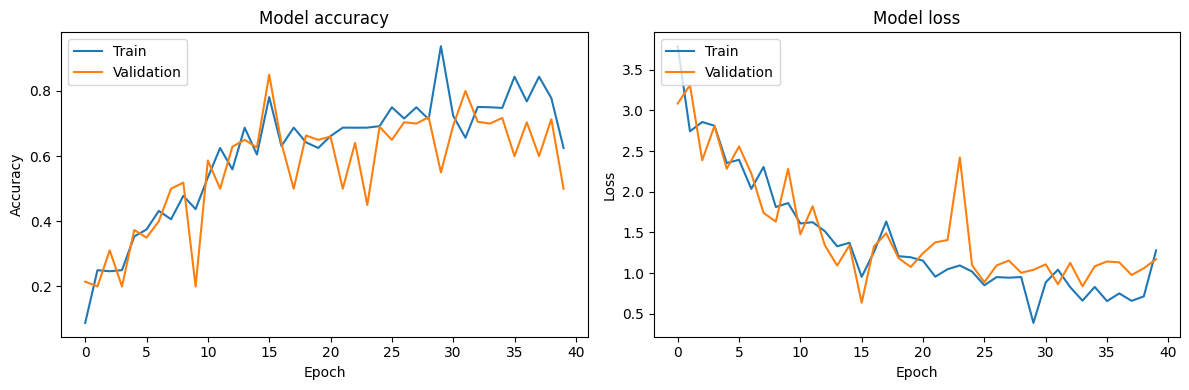

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


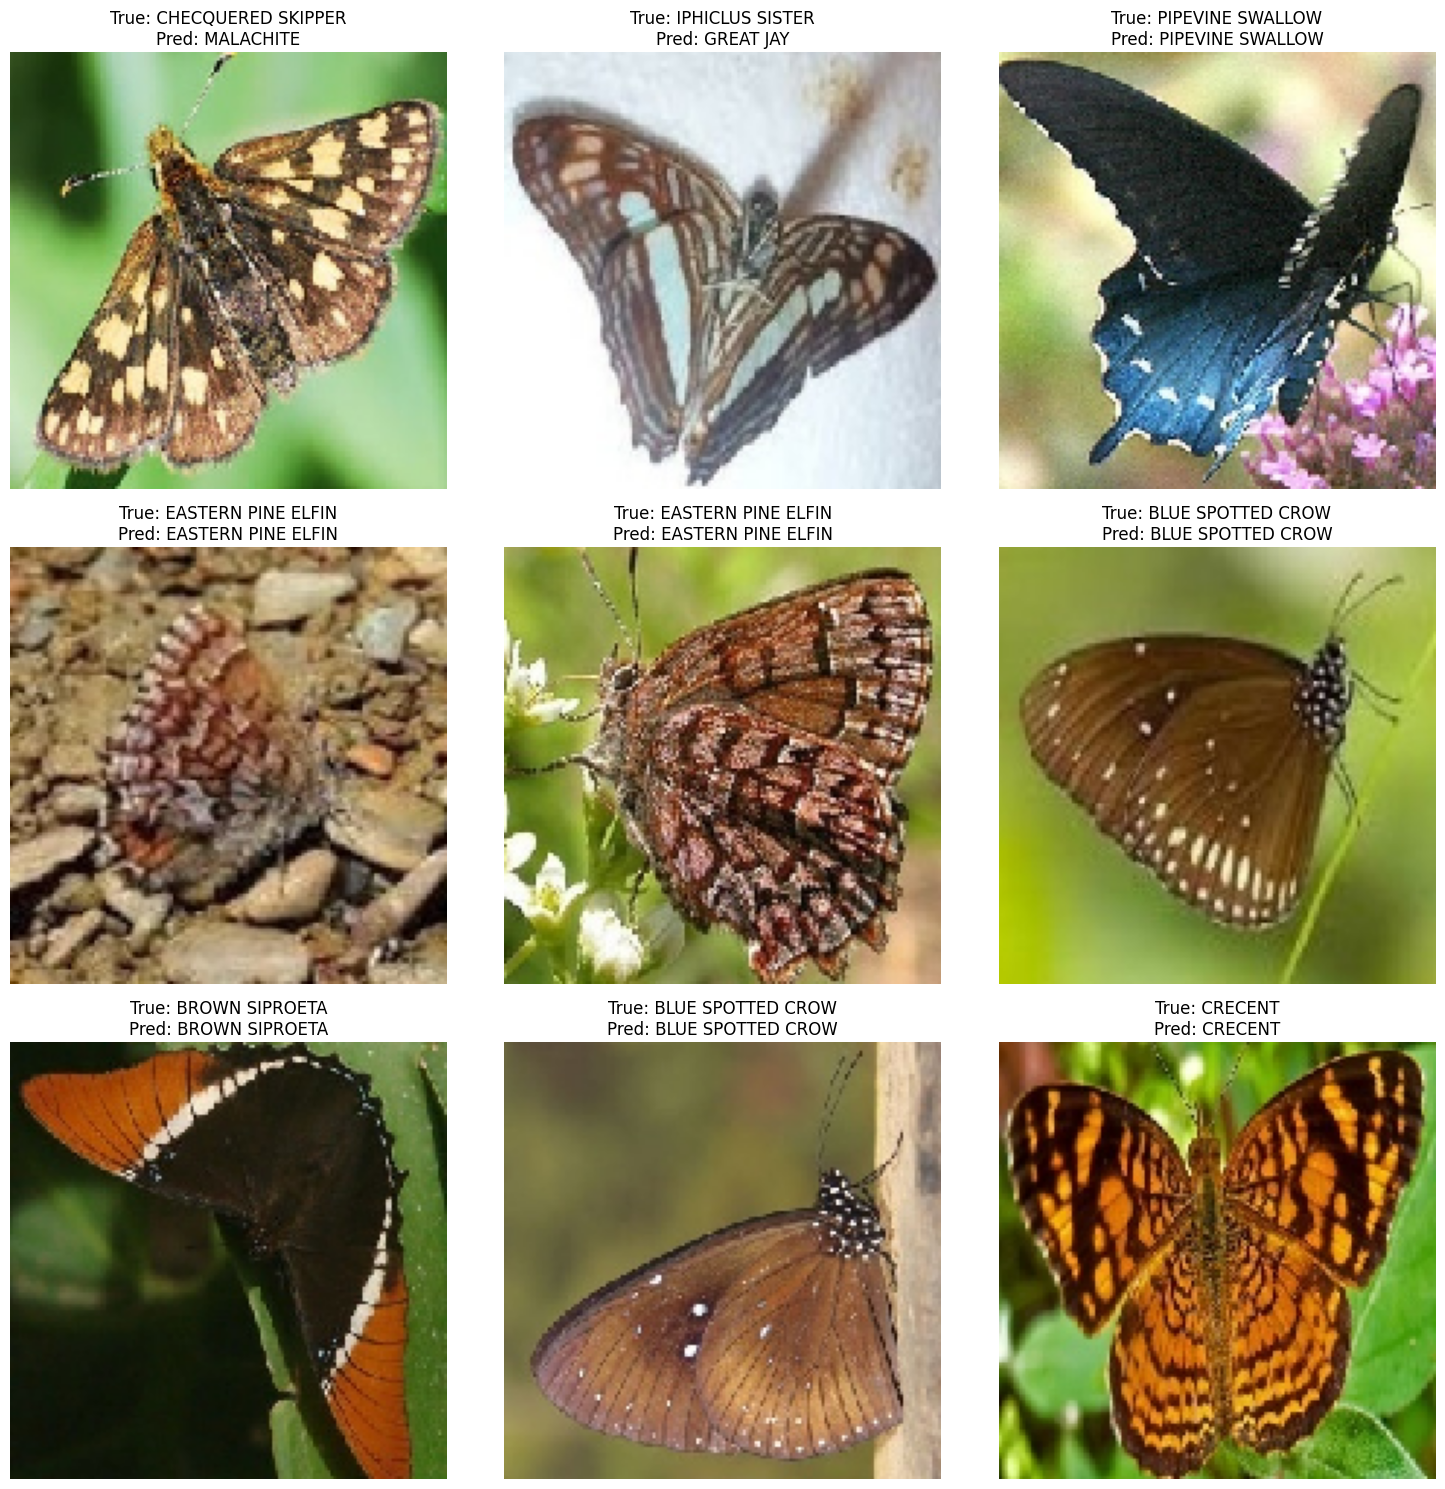

In [ ]:
val_images, val_labels = next(val_generator)

pred_labels = model_CNN.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=9)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
X_train_flattened = np.array([img_to_array(load_img(os.path.join(image_dir, fname), target_size=(150, 150))).flatten() for fname in train_df['filename']])
X_val_flattened = np.array([img_to_array(load_img(os.path.join(image_dir, fname), target_size=(150, 150))).flatten() for fname in val_df['filename']])

In [ ]:
X_train_flattened = X_train_flattened / 255.0
X_val_flattened = X_val_flattened / 255.0

In [ ]:
y_train = train_generator.classes
y_val = val_generator.classes

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Using fewer estimators to speed up training
rf_clf = RandomForestClassifier(n_estimators=10, random_state=42)  # Reduced to 10 estimators
rf_clf.fit(X_train_flattened[:500], y_train[:500])  # Using a smaller subset of 500 samples
y_pred_rf = rf_clf.predict(X_val_flattened)
rf_acc = accuracy_score(y_val, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

Random Forest Accuracy: 0.0685


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Using a smaller subset of the training data
knn_clf = KNeighborsClassifier(n_neighbors=3)  # Reduced to 3 neighbors
knn_clf.fit(X_train_flattened[:500], y_train[:500])  # Using a smaller subset of 500 samples
y_pred_knn = knn_clf.predict(X_val_flattened)
knn_acc = accuracy_score(y_val, y_pred_knn)
print(f"KNN Accuracy: {knn_acc:.4f}")

KNN Accuracy: 0.0615


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Using a smaller subset of the training data
svm_clf = SVC(kernel='linear')  # Keeping the linear kernel for simplicity
svm_clf.fit(X_train_flattened[:500], y_train[:500])  # Using a smaller subset of 500 samples
y_pred_svm = svm_clf.predict(X_val_flattened)
svm_acc = accuracy_score(y_val, y_pred_svm)
print(f"SVM Accuracy: {svm_acc:.4f}")

SVM Accuracy: 0.1315


In [ ]:
# Assuming the CNN model is already defined
history = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Keeping it 10 for simplicity
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Retrieve the final validation accuracy from the history object
cnn_acc = history.history['val_accuracy'][-1]
print(f"CNN Accuracy: {cnn_acc:.4f}")

Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.1411 - loss: 3.5155

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 144s 884ms/step - accuracy: 0.1417 - loss: 3.5125 - val_accuracy: 0.3664 - val_loss: 2.4075
Epoch 2/10
  1/162 ━━━━━━━━━━━━━━━━━━━━ 2:06 786ms/step - accuracy: 0.5938 - loss: 1.5730

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.5730 - val_accuracy: 0.3500 - val_loss: 2.4202
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 143s 882ms/step - accuracy: 0.5583 - loss: 1.6306 - val_accuracy: 0.4586 - val_loss: 2.0605
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 1.5979 - val_accuracy: 0.4500 - val_loss: 2.4825
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 145s 889ms/step - accuracy: 0.8046 - loss: 0.7113 - val_accuracy: 0.4734 - val_loss: 2.3977
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.6562 - loss: 1.0104 - val_accuracy: 0.3000 - val_loss: 2.7863
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 200s 881ms/step - accuracy: 0.9399 - loss: 0.2204 - val_accuracy: 0.4961 - val_loss: 2.7391
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.9062 - loss: 0.3976 - val_accuracy: 0.4500 - val_loss: 2.5632
Epoch 9/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 144s 884ms/step - accuracy: 0.9770 - loss: 0.0842 - val_acc

In [ ]:
algorithms = ['Random Forest', 'KNN', 'SVM','CNN']
accuracies = [rf_acc, knn_acc, svm_acc, cnn_acc]

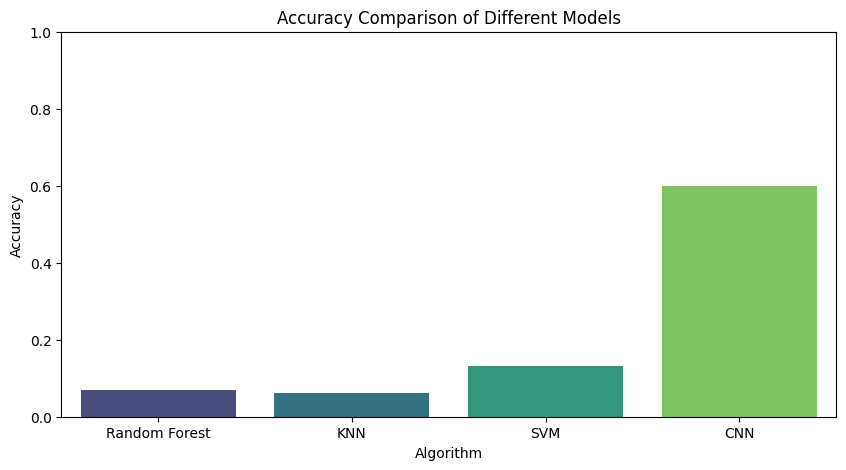

In [ ]:
plt.figure(figsize=(10, 5))

# Convert the 'algorithms' list to a pandas Series or NumPy array to avoid the FutureWarning
algorithms = np.array(algorithms)

sns.barplot(x=algorithms, y=accuracies, palette='viridis')
plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()